In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

C:\Users\Shreevara\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Shreevara\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Shreevara\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Shreevara\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
train_data = []
train_labels = []
classes = 43
cur_path = os.getcwd()

#Retrieving the images and their labels 
for i in range(43):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

#print(path)
#print(images[:3])

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((32,32))
            image = np.array(image)
            train_data.append(image)
            train_labels.append(i)
        except:
            print("Error loading image")
#print(image)
#print(labels)

#Converting lists into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_labels)
print(train_data.shape, train_labels.shape)

[ 0  0  0 ... 42 42 42]
(39209, 32, 32, 3) (39209,)


In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


In [4]:
# Let's get some dimensions
print("Features shape: ", X_train.shape)
print("Leatures shape: ", y_train.shape)

Features shape:  (31367, 32, 32, 3)
Leatures shape:  (31367,)


In [5]:
y_test = pd.read_csv('Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((32,32))
    data.append(np.array(image))

X_test=np.array(data)
print(X_test.shape)

(12630, 32, 32, 3)


In [6]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [7]:
# Load sign names file
sign_names = pd.read_csv("labels.csv")
sign_names.set_index("ClassId")

sign_names.head(5)

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [8]:
def group_img_id_to_lbl(lbs_ids, lbs_names):    
   
    #Utility function to group images by label 

    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["Name"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})
    
    return pd.DataFrame(arr_map)


X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)



def group_img_id_to_lb_count(img_id_to_lb):
   
#Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    
    return pd.pivot_table(img_id_to_lb,index=["label_id","label_name"],values=["img_id"], aggfunc='count')

# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),172
1,Speed limit (30km/h),1724
2,Speed limit (50km/h),1800
3,Speed limit (60km/h),1130
4,Speed limit (70km/h),1562


In [16]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    
    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))
        
        if not show_ticks:            
            axes[i].axis("off")
            
        axes[i].imshow(img, cmap=cmap)
    
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()
    
    return


def show_random_dataset_images(group_label, imgs, to_show=5):
    """
    This function takes a DataFrame of items group by labels as well as a set of images and randomly selects to_show images to display
    """
    for (lid, lbl), group in group_label:
        #print("[{0}] : {1}".format(lid, lbl))    
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(7, 7), show_ticks=False)

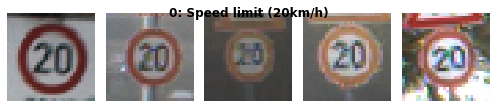

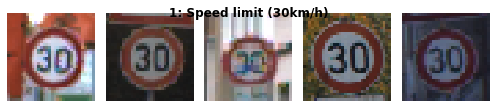

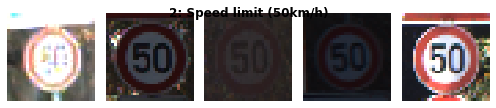

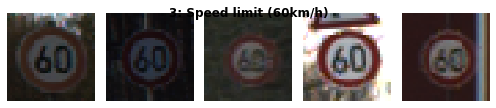

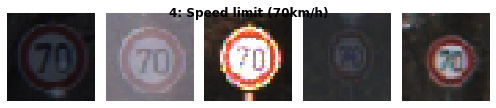

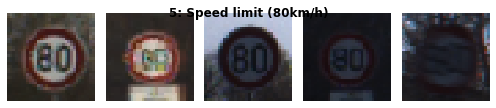

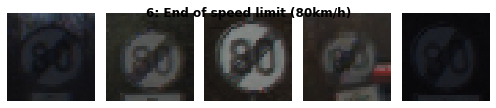

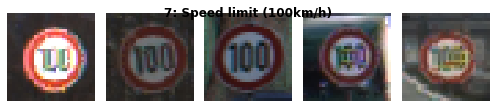

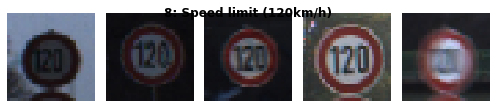

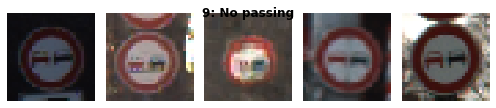

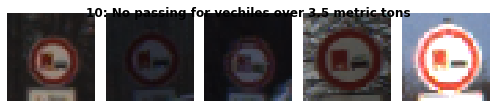

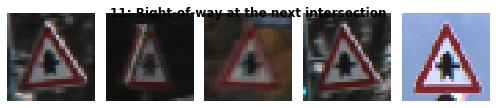

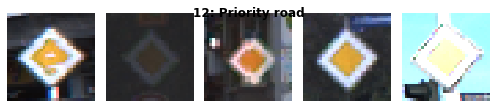

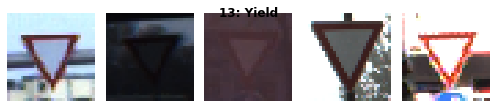

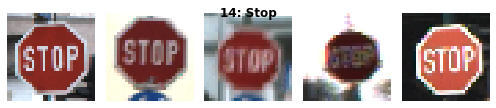

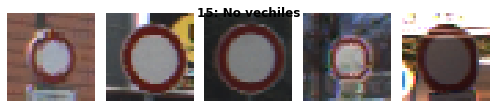

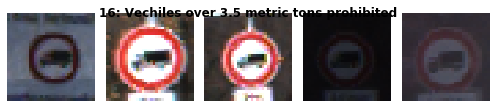

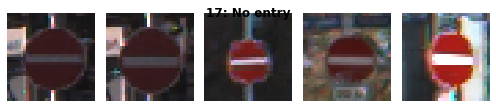

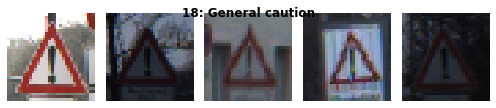

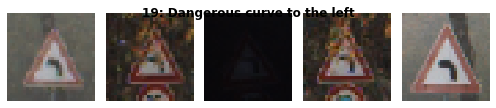

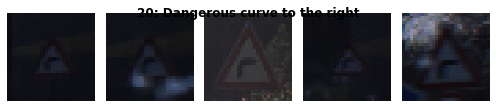

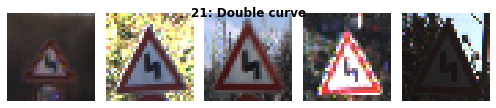

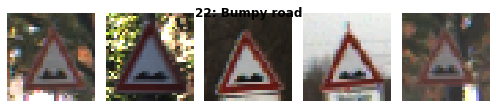

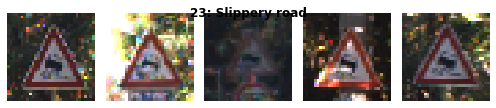

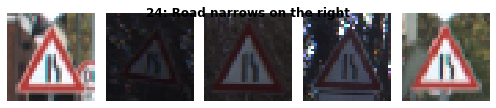

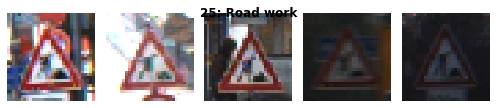

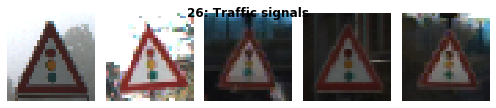

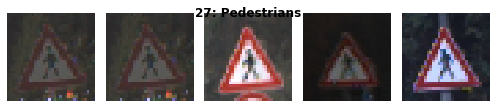

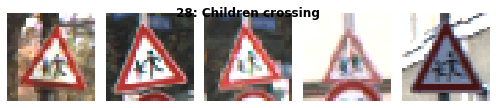

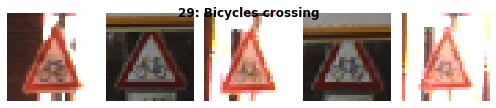

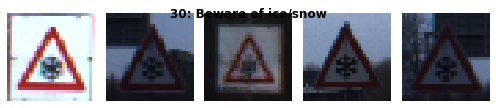

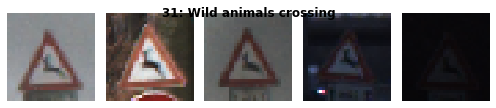

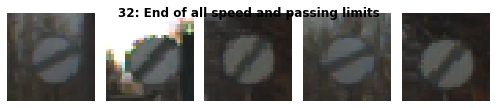

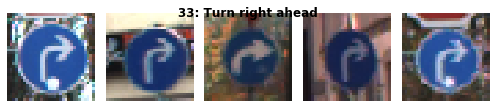

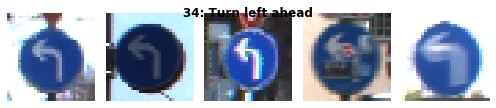

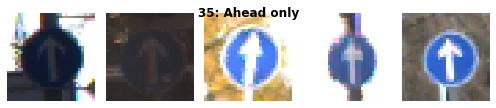

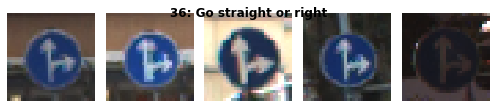

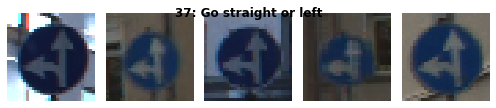

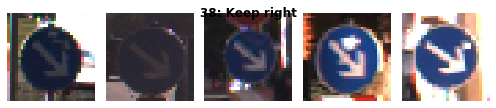

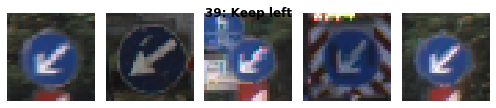

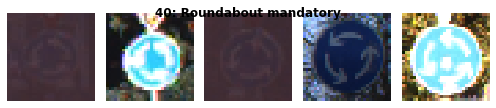

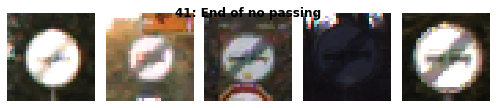

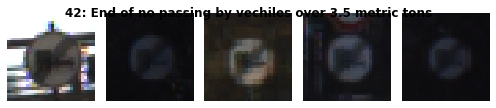

In [17]:
# Let's plot images from each of these classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)    

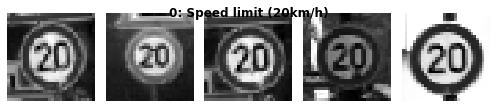

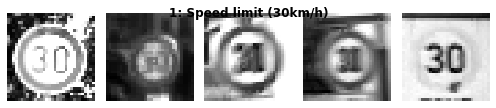

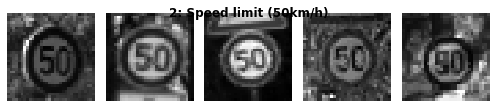

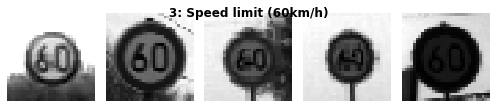

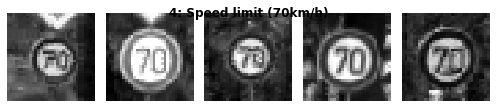

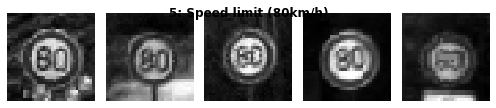

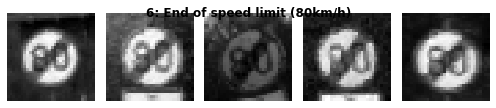

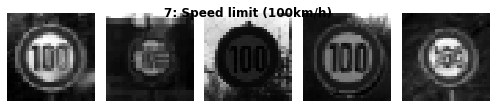

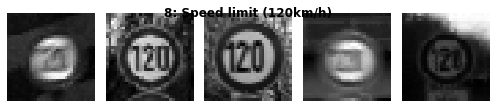

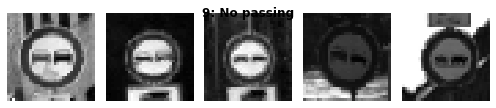

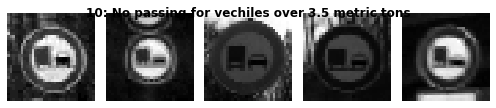

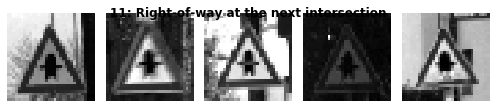

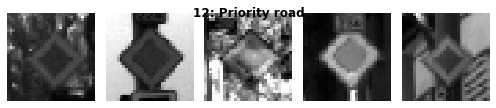

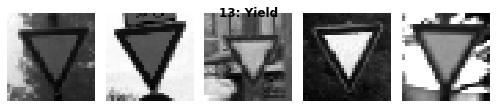

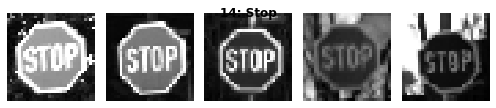

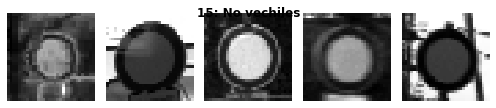

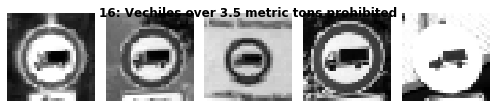

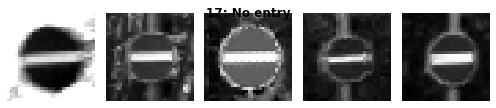

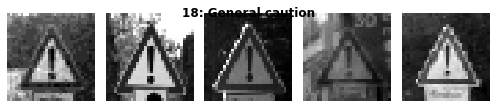

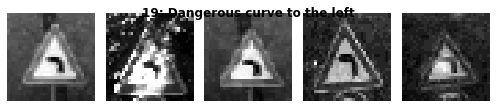

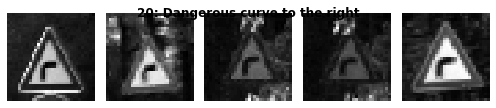

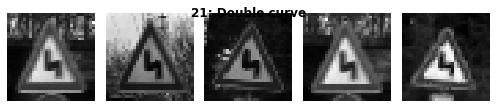

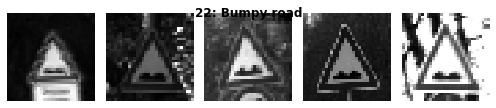

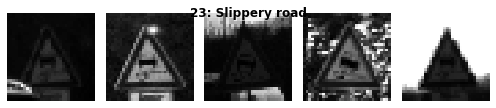

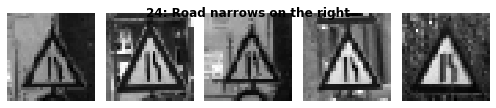

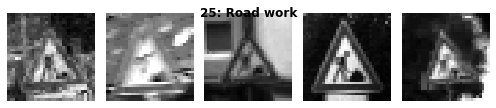

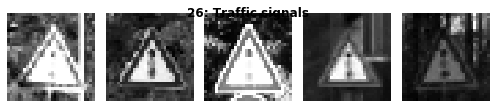

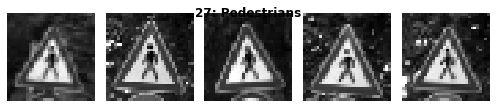

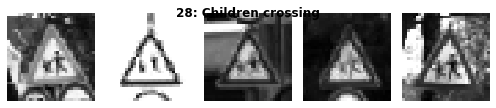

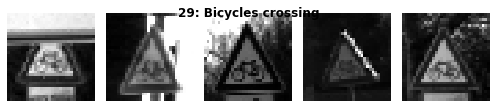

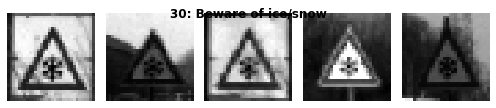

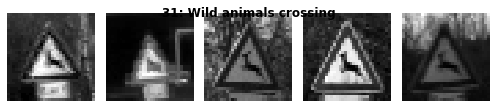

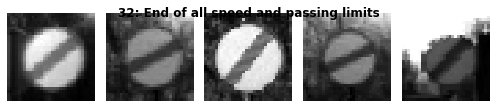

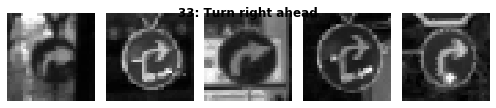

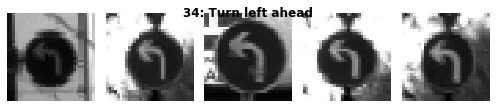

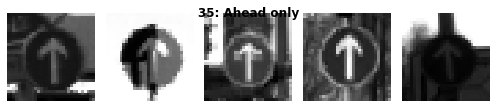

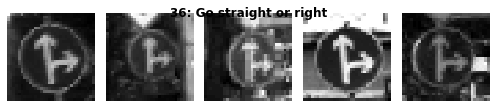

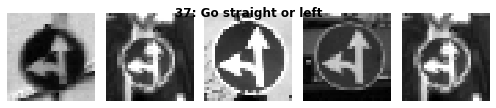

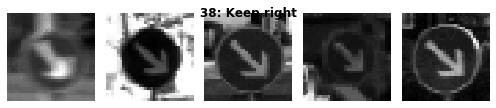

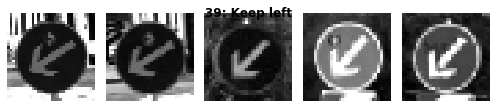

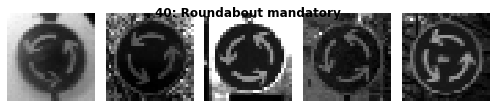

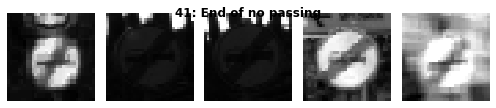

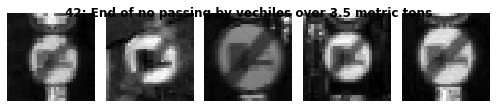

In [18]:
def to_grayscale(img):
    """
    Converts an image in RGB format to grayscale
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# Let's test our image graying features on training set
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

In [19]:
# Do the same on validation set
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid))) 

# Also grayscale test data
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test))) 

In [20]:
X_train_grayscale = np.reshape(X_train_grayscale, (X_train_grayscale.shape[0], 32, 32, 1))
X_valid_grayscale = np.reshape(X_valid_grayscale, (X_valid_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [22]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)

In [23]:
#Building the model
model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_grayscale.shape[1:]))
model3.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(rate=0.25))

model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(rate=0.25))

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(43, activation='softmax'))

#Compilation of the model
model3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

epochs = 15

model_3 = model3.fit(X_train_grayscale, 
                    y_train, 
                    batch_size=32, 
                    epochs=epochs, 
                    validation_data=(X_valid_grayscale, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 31367 samples, validate on 7842 samples
Epoch 1/15
31367/31367 [==============================] - 117s 4ms/step - loss: 1.6877 - acc: 0.5689 - val_loss: 0.3884 - val_acc: 0.8995
Epoch 2/15
31367/31367 [==============================] - 120s 4ms/step - loss: 0.5737 - acc: 0.8270 - val_loss: 0.1903 - val_acc: 0.9480
Epoch 3/15
31367/31367 [==============================] - 121s 4ms/step - loss: 0.4058 - acc: 0.8762 - val_loss: 0.1243 - val_acc: 0.9676
Epoch 4/15
31367/31367 [==============================] - 117s 4ms/step - loss: 0.3373 - acc: 0.8979 - val_loss: 0.0988 - val_acc: 0.9721
Epoch 5/15
31367/31367 [==============================] - 114s 4ms/step - loss: 0.2846 - acc: 0.9150 - val_loss: 0.0793 - val_acc: 0.9756
Epoch 6/15
31367/31367 [==============================] - 112s 4ms/step - loss: 0.2557 - acc: 0.9247 - val_loss: 0.0766 - val_acc: 0.9770
Epoch 7/15
31367/31367 [=====

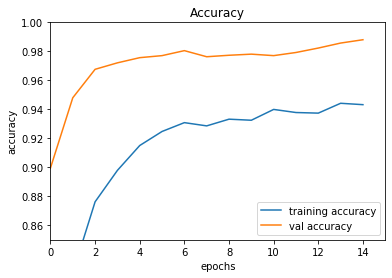

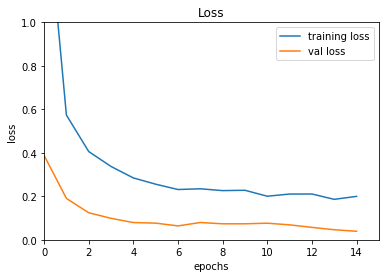

In [24]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model_3.history['acc'], label='training accuracy')
plt.plot(model_3.history['val_acc'], label='val accuracy')
plt.xlim(0, 15)
plt.ylim(0.85, 1)
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(model_3.history['loss'], label='training loss')
plt.plot(model_3.history['val_loss'], label='val loss')
plt.xlim(0, 15)
plt.ylim(0, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [25]:
model3.save("grayscale1.h5")

In [26]:
pred = model3.predict_classes(X_test_grayscale)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

0.9542359461599367


In [30]:
def normalise_images(imgs, dist):

    #Normalise the images from data in dist
  
    std = np.std(dist)
    mean = np.mean(dist)
    return (imgs - mean) / std


X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_valid_grayscale_normalised = normalise_images(X_valid_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [39]:
#Building the model
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_grayscale.shape[1:]))
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(rate=0.25))

model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(rate=0.25))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(43, activation='softmax'))

#Compilation of the model
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

epochs = 15

model_2 = model2.fit(X_train_grayscale_normalised, 
                    y_train, 
                    batch_size=32, 
                    epochs=epochs, 
                    validation_data=(X_valid_grayscale_normalised, y_valid))

Train on 31367 samples, validate on 7842 samples
Epoch 1/15
31367/31367 [==============================] - 125s 4ms/step - loss: 1.0312 - acc: 0.7104 - val_loss: 0.1103 - val_acc: 0.9702
Epoch 2/15
31367/31367 [==============================] - 113s 4ms/step - loss: 0.2087 - acc: 0.9371 - val_loss: 0.0700 - val_acc: 0.9779
Epoch 3/15
31367/31367 [==============================] - 112s 4ms/step - loss: 0.1407 - acc: 0.9584 - val_loss: 0.0648 - val_acc: 0.9810
Epoch 4/15
31367/31367 [==============================] - 109s 3ms/step - loss: 0.1077 - acc: 0.9682 - val_loss: 0.0415 - val_acc: 0.9881
Epoch 5/15
31367/31367 [==============================] - 110s 3ms/step - loss: 0.0958 - acc: 0.9713 - val_loss: 0.0264 - val_acc: 0.9922
Epoch 6/15
31367/31367 [==============================] - 112s 4ms/step - loss: 0.0863 - acc: 0.9747 - val_loss: 0.0301 - val_acc: 0.9921
Epoch 7/15
31367/31367 [==============================] - 111s 4ms/step - loss: 0.0693 - acc: 0.9786 - val_loss: 0.0325 - v

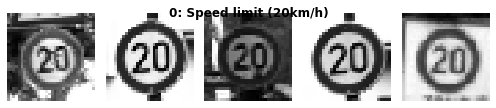

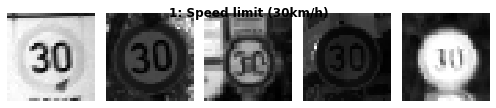

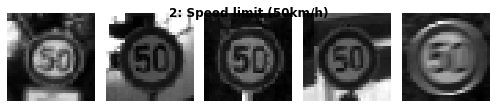

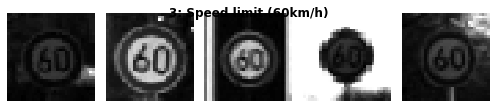

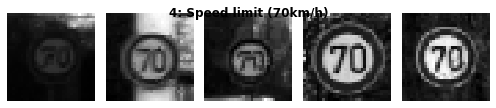

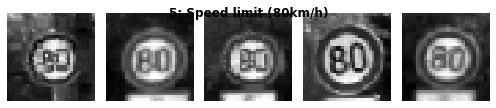

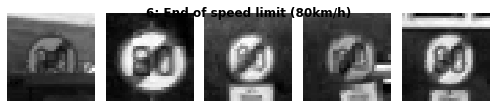

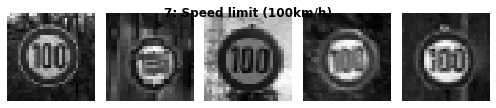

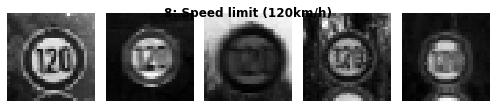

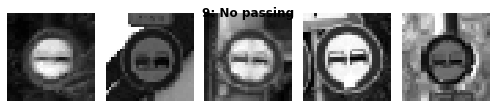

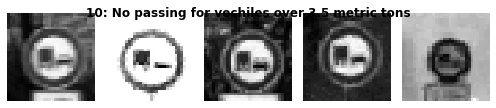

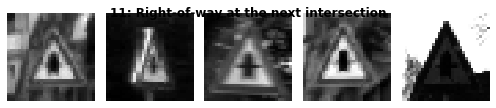

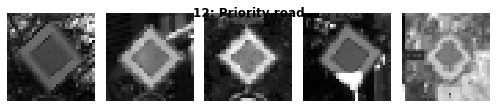

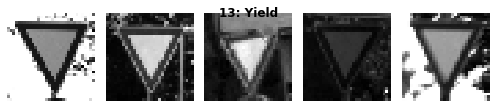

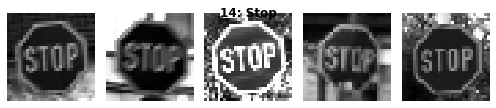

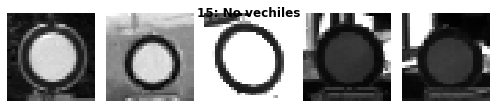

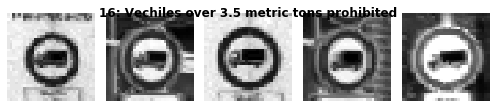

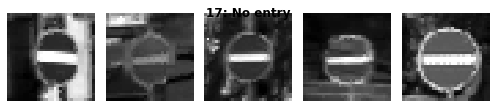

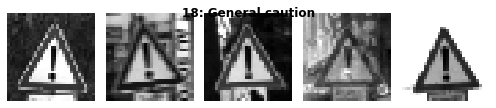

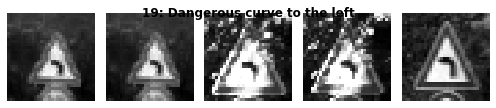

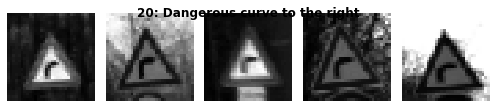

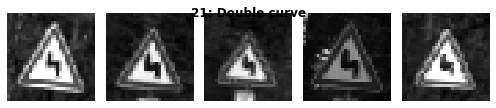

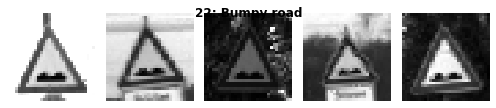

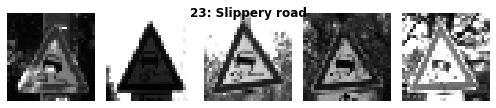

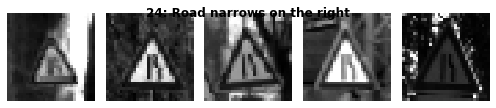

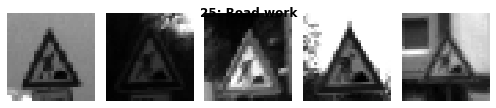

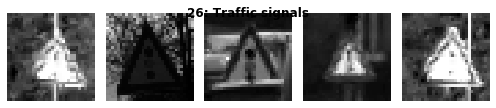

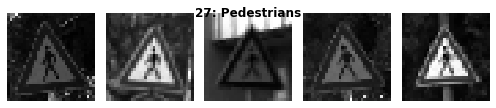

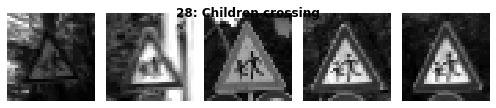

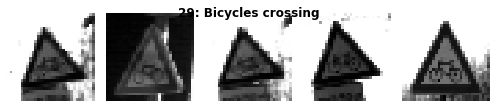

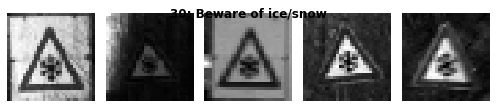

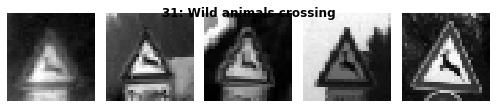

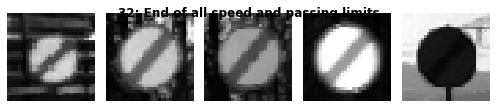

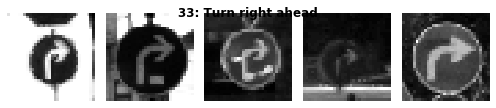

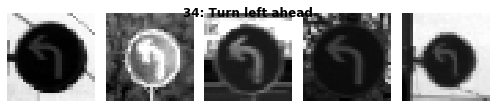

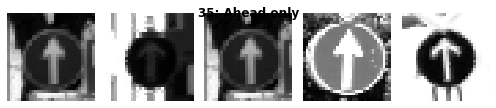

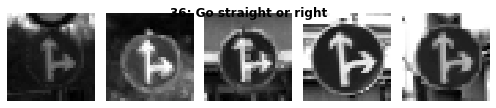

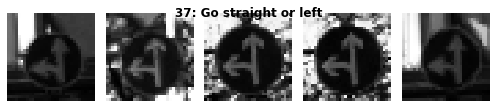

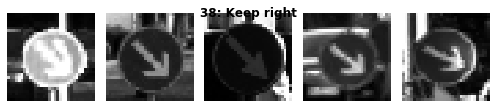

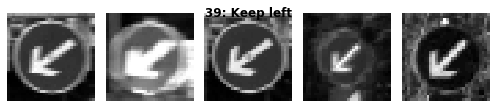

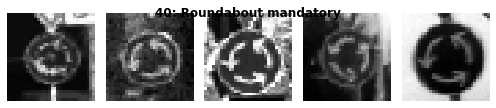

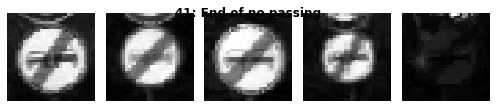

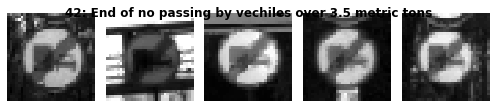

In [41]:
show_random_dataset_images(X_train_group_by_label, X_train_grayscale_normalised)

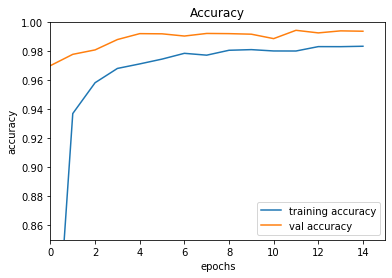

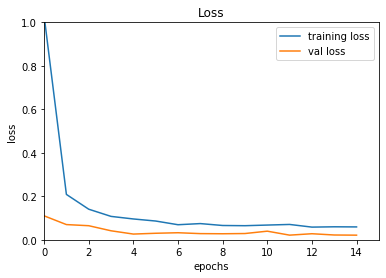

In [42]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model_2.history['acc'], label='training accuracy')
plt.plot(model_2.history['val_acc'], label='val accuracy')
plt.xlim(0, 15)
plt.ylim(0.85, 1)
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(model_2.history['loss'], label='training loss')
plt.plot(model_2.history['val_loss'], label='val loss')
plt.xlim(0, 15)
plt.ylim(0, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

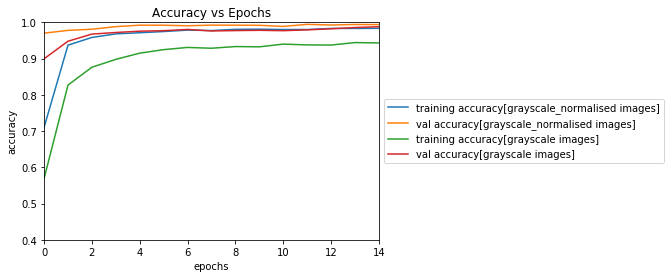

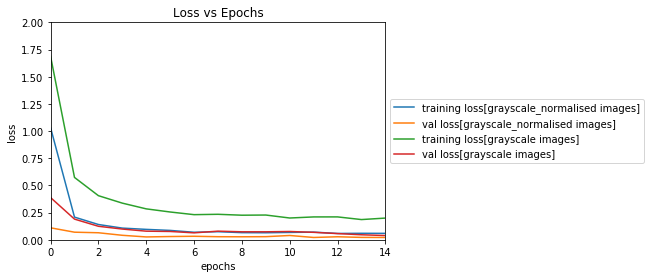

In [43]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(model_2.history['acc'], label='training accuracy[grayscale_normalised images]')
plt.plot(model_2.history['val_acc'], label='val accuracy[grayscale_normalised images]')
plt.plot(model_3.history['acc'], label='training accuracy[grayscale images]')
plt.plot(model_3.history['val_acc'], label='val accuracy[grayscale images]')
plt.xlim(0, 14)
plt.ylim(0.4, 1)
plt.title('Accuracy vs Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(1)
plt.plot(model_2.history['loss'], label='training loss[grayscale_normalised images]')
plt.plot(model_2.history['val_loss'], label='val loss[grayscale_normalised images]')
plt.plot(model_3.history['loss'], label='training loss[grayscale images]')
plt.plot(model_3.history['val_loss'], label='val loss[grayscale images]')
plt.xlim(0, 14)
plt.ylim(0, 2)
plt.title('Loss vs Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [44]:
model2.save("grayscale_norm1.h5")

In [50]:
pred = model2.predict_classes(X_test_grayscale_normalised)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

0.9697545526524148


In [51]:
sign_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)\
', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)\
', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons\
', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles\
', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left\
', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right\
', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing \
', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits\
', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right\
', 'Keep left', 'Roundabout mandatory', 'End of no passing','End of no passing by vehicles over 3.5 metric tons']

(32, 32, 1)
predicted sign is: [5] Speed limit (80km/h)
Actual classId : 5


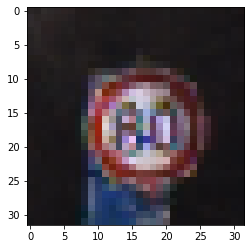

In [71]:
#prediction of 222th image from model1
plt.imshow(X_test[222])
print(X_test_grayscale_normalised[222].shape)

prediction=str(model2.predict_classes(X_test_grayscale_normalised[222].reshape(1,32,32,1)))


pred_value = prediction[1:2]
pred_statement = sign_names[int(pred_value)]

print("predicted sign is: " + prediction + " " + pred_statement)

#actual classId to which the image is belonged to:-
print("Actual classId :", labels[222])
